# Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import infomap           as im
import matplotlib.pyplot as plt
import networkx          as nx
import numpy             as np
import pandas            as pd
import seaborn           as sb

from analysis import *
from os.path  import exists

In [2]:
colours = ["windows blue", "amber", "pale red", "greyish", "faded green", "dusty purple", "orange"]

sb.set()
sb.set_style("whitegrid", {'grid.linestyle': '--'}),
sb.set_palette(sb.xkcd_palette(colours))

# Load data

In [3]:
!mkdir -p ../data
!curl https://networks.skewed.de/net/facebook_organizations/files/L2.csv.zip > ../data/facebook-organizations.zip
!unzip -p ../data/facebook-organizations.zip edges.csv > ../data/facebook-organizations.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  353k  100  353k    0     0   818k      0 --:--:-- --:--:-- --:--:--  816k


In [4]:
G_raw = nx.Graph()

with open("../data/facebook-organizations.csv", "r") as fh:
    fh.readline()
    for line in fh:
        u,v = line.strip().split(",")
        G_raw.add_edge(u,v)

G = G_raw.subgraph(max(nx.connected_components(G_raw), key=len)).copy()

In [5]:
with open("../data/facebook-organizations.edgelist", "w") as fh:
    for (u,v) in G.edges:
        fh.write(f"{u} {v}\n")

# Community structure with Louvain

In [6]:
partition   = nx.algorithms.community.louvain_communities(G, seed = 0)
partition_Q = nx.algorithms.community.modularity(G, partition)

for seed in Bar("Progress", check_tty = False).iter(range(1,1000)):
    partition_   = nx.algorithms.community.louvain_communities(G, seed = seed)
    partition_Q_ = nx.algorithms.community.modularity(G, partition_)
    
    if partition_Q_ > partition_Q:
        partition   = partition_
        partition_Q = partition_Q_

Progress |################################| 999/999


In [7]:
communities = { community_ID : set(community) for (community_ID, community) in enumerate(partition, start = 1)}

In [8]:
community_assignments = dict()
for (community_ID, community) in communities.items():
    for node in community:
        community_assignments[node] = community_ID

# Some data statistics

In [9]:
showStats(G, community_assignments, communities)

#nodes:       5524
#edges:       94219
#communities: 13
#eff. comm.:  9
<k>:          34.113
<k²>:         2175.633
transitivity: 0.222
mixing:       0.228
λth:          0.016


# Calculate / load centrality scores

In [10]:
results_file = "../results/facebook-organizations-modularity.csv"

if not exists(results_file):
    # Community Hub Bridge
    com_hb_ranks = calculate_community_hub_bridge_ranks(G = G, communities = communities, community_assignments = community_assignments)
    
    # Community-based Centrality
    com_bc_ranks = calculate_community_based_centrality_ranks(G = G, communities = communities, community_assignments = community_assignments)

    # Modularity Vitality
    mod_vit_ranks = calculate_modularity_vitality_ranks(G = G, partition = partition)
    
    # Map Equation Centrality
    tree_file = "../results/facebook-organizations-temp.tree"

    # use Infomap to write a tree file that we change to reflect the Louvain partition
    infomap = im.Infomap(silent = True, num_trials = 1, directed = False, two_level = True, seed = 42)
    infomap.add_networkx_graph(G)
    infomap.run()
    infomap.write_tree(tree_file)
    
    infomap_tree = dict()

    # read the tree file
    with open(tree_file, "r") as fh:
        for line in fh:
            if not line.startswith("#"):
                _, flow, name, node_id = line.strip().split(" ")
                name = name[1:-1]
                infomap_tree[name] = (flow, node_id)
    
    # write the Louvain partition to an Infomap tree file
    with open("../results/facebook-organizations-modularity.tree", "w") as fh:
        for community_ID, community in enumerate(partition, start = 1):
            for node_pos, node in enumerate(community, start = 1):
                path = f"{community_ID}:{node_pos}"
                flow, node_id = infomap_tree[node]
                fh.write(f"{path} {flow} \"{node}\" {node_id}\n")
    
    # Load the Louvain partition with Infomap and use unrecorded link teleportation
    infomap2 = im.Infomap("--silent --no-infomap --cluster-data ../results/facebook-organizations-modularity.tree")
    node_mapping = infomap2.add_networkx_graph(G)
    infomap2.run()
    
    mec_ranks = [ node for node, _score in sorted( [ (node_mapping[node.node_id], node.modular_centrality) for node in infomap2.iterLeafNodes() ]
                                                 , key     = second
                                                 , reverse = True
                                                 )]
    
    # Load the Louvain partition with Infomap and use recorded node teleportation
    infomap3 = im.Infomap("--silent --no-infomap --directed --recorded-teleportation --to-nodes --cluster-data ../results/facebook-organizations-modularity.tree")
    node_mapping_pr = infomap3.add_networkx_graph(G)
    infomap3.run()
    
    mec_ranks_pr = [ node for node, _score in sorted( [ (node_mapping_pr[node.node_id], node.modular_centrality) for node in infomap3.iterLeafNodes() ]
                                                    , key     = second
                                                    , reverse = True
                                                    )]
    
    # Degree and betweenness centrality
    dc_ranks      = [ node for node, _score in sorted( nx.algorithms.centrality.degree_centrality(G).items()
                                                     , key     = second
                                                     , reverse = True
                                                     )]
    between_ranks = [ node for node, _score in sorted( nx.algorithms.centrality.betweenness_centrality(G).items()
                                                     , key     = second
                                                     , reverse = True
                                                     )]
    
    results = pd.DataFrame()
    results.index = G.nodes

    results["map equation centrality rank"]       = toRanking(mec_ranks,        results.index)
    results["map equation centrality rank pr"]    = toRanking(mec_ranks_pr,     results.index)
    results["modularity vitality rank"]           = toRanking(mod_vit_ranks,    results.index)
    results["community hub-bridge rank"]          = toRanking(com_hb_ranks,     results.index)
    results["community-based centrality rank"]    = toRanking(com_bc_ranks,     results.index)
    results["degree centrality rank"]             = toRanking(dc_ranks,         results.index)
    results["betweenness centrality rank"]        = toRanking(between_ranks,    results.index)

    results.to_csv(results_file)

else:
    results = pd.read_csv(results_file, index_col = 0)

    mec_ranks         = mkRanks(results["map equation centrality rank"])
    mec_ranks_pr      = mkRanks(results["map equation centrality rank pr"])
    mod_vit_ranks     = mkRanks(results["modularity vitality rank"])
    com_hb_ranks      = mkRanks(results["community hub-bridge rank"])
    com_bc_ranks      = mkRanks(results["community-based centrality rank"])
    dc_ranks          = mkRanks(results["degree centrality rank"])
    between_ranks     = mkRanks(results["betweenness centrality rank"])

Community Hub Bridge |#################               | 2998/5524IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Community Hub Bridge |################################| 5524/5524
Community-based Centrality |##############                  | 2497/5524IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Community-based Centrality |################################| 5524/5524
Modularity Vitality |################################| 5524/5524


# SIR

In [11]:
if not exists("../data/facebook-friends.spreading_power"):
    !../spreading-power-exe --input ../data/facebook-organizations.edgelist \
                            --output ../data/facebook-organizations.spreading_power \
                            --seed 42 \
                            --iterations 1000 \
                            --directed

In [12]:
spreading_power = dict()
with open("../data/facebook-organizations.spreading_power") as fh:
    for line in fh:
        node, power = line.strip().split(" ")
        spreading_power[node] = float(power)

In [13]:
sir_ranks = [ node for node, _score 
              in sorted( spreading_power.items()
                       , key     = lambda p: p[1]
                       , reverse = True
                       )
            ]

# Plotting

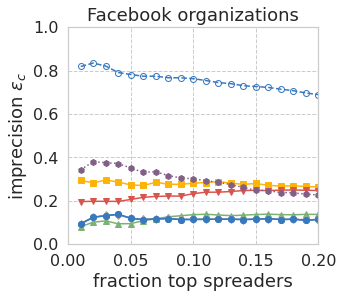

In [14]:
node_fractions = [0.01 * p for p in range (1,21)]

mec_x,     mec_y     = zip(*get_imperfections(mec_ranks,         sir_ranks, spreading_power, node_fractions = node_fractions))
mec_pr_x,  mec_pr_y  = zip(*get_imperfections(mec_ranks_pr,      sir_ranks, spreading_power, node_fractions = node_fractions))
mod_vit_x, mod_vit_y = zip(*get_imperfections(mod_vit_ranks,     sir_ranks, spreading_power, node_fractions = node_fractions))
com_hb_x,  com_hb_y  = zip(*get_imperfections(com_hb_ranks,      sir_ranks, spreading_power, node_fractions = node_fractions))
com_bc_x,  com_bc_y  = zip(*get_imperfections(com_bc_ranks,      sir_ranks, spreading_power, node_fractions = node_fractions))
dc_x,      dc_y      = zip(*get_imperfections(dc_ranks,          sir_ranks, spreading_power, node_fractions = node_fractions))
between_x, between_y = zip(*get_imperfections(between_ranks,     sir_ranks, spreading_power, node_fractions = node_fractions))

fig = plt.figure(figsize = (5,4.3))

plt.plot(mec_x,     mec_y,     marker = "o", color = sb.color_palette()[0], label = "map equation centrality")
plt.plot(mod_vit_x, mod_vit_y, marker = "s", color = sb.color_palette()[1], label = "modularity vitality")
plt.plot(com_hb_x,  com_hb_y,  marker = "v", color = sb.color_palette()[2], label = "community hub bridge")
plt.plot(com_bc_x,  com_bc_y,  marker = "^", color = sb.color_palette()[4], label = "comm.-based centrality")
plt.plot(dc_x,      dc_y,      marker = "d", color = sb.color_palette()[3], linestyle = "dotted", label = "degree centrality")
plt.plot(between_x, between_y, marker = "h", color = sb.color_palette()[5], linestyle = "dotted", label = "betweenness centrality")
plt.plot(mec_pr_x,  mec_pr_y,  marker = "o", color = sb.color_palette()[0], linestyle = "--", fillstyle = "none")
plt.plot(mec_x,     mec_y,     marker = "o", color = sb.color_palette()[0])

plt.title("Facebook organizations", fontsize = 18)
plt.ylabel("imprecision $\epsilon_c$", fontsize = 18)
plt.xlabel("fraction top spreaders", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(0.0,0.2)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("../plots/sir-facebook-organizations-modularity.pdf")

In [15]:
!pdfcrop ../plots/sir-facebook-organizations-modularity.pdf
!mv ../plots/sir-facebook-organizations-modularity-crop.pdf ../plots/sir-facebook-organizations-modularity.pdf

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/sir-facebook-organizations-modularity-crop.pdf'.
